# Data Visualization Notebook

## Objectives

*   Answer business requirement 1: 
    *  A study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew


## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between parasite-contained and uninfected cell images.
* Generate code that can be used to build an image montage on the Streamlit dashboard.


## Additional Comments | Insights | Conclusions


---

# Set Data Directory

---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/pp5-mildew-detection')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/pp5-mildew-detection'

## Set input directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory


In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('A prior version is in place; proceed with making a new version.')
    pass
else:
    os.makedirs(name=file_path)

A prior version is in place; proceed with making a new version.


### Set label names

In [7]:
labels = os.listdir(train_path)
print('The following are labels for the images:', labels)

The following are labels for the images: ['healthy', 'powdery_mildew']


---

# Visual representation of image data

---

## Image shape 

Compute average images size on train set.

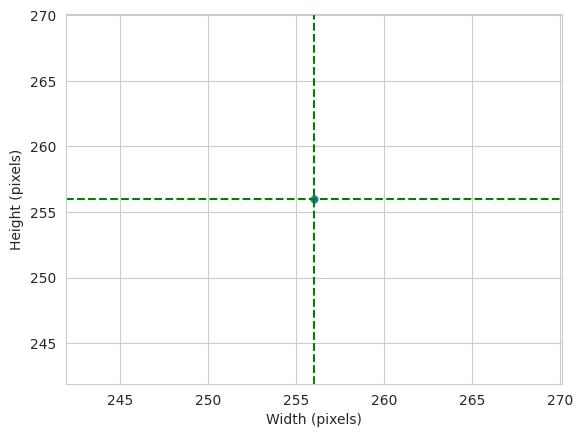

Mean width of images: 256 
Mean height of images: 256


In [8]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        height1, with2, colors = img.shape
        dim1.append(height1)  
        dim2.append(with2)  

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='g', linestyle='--')
axes.axhline(y=dim2_mean, color='g', linestyle='--')
plt.show()
print(f"Mean width of images: {dim2_mean} \nMean height of images: {dim1_mean}")

The training images are resized to the average dimensions of all images in the train set.

In [9]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save the image shape embeddings

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Mean and variability of images  per label

### Function to load images in an array (tensor)

In [24]:
from tensorflow.keras.preprocessing import image


def image_load_as_array(my_data_dir, new_size=(50, 50), imgs_per_label=30):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < imgs_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

### Load image shapes and labels in an array

In [25]:
X, y = image_load_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           imgs_per_label=30)
print(X.shape, y.shape)


(60, 256, 256, 3) (60,)


### Plot and save mean and variability of images per label

In [30]:
def plot_average_variability_per_labels(X, y, figsize=(12, 5), save_img=False):
    """
    The pseudo-code for the function is:
    * Iterate through each label.
    * Extract a subset of an array corresponding to each label
    * Compute the average and standard deviation for the subset.
    * Generate a figure that shows the mean and variability of the images.
    * Save the generated figure as an image file.
    """

    for selected_label in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == selected_label, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {selected_label} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Mean for image label {selected_label}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {selected_label}")
        axes[1].imshow(std_img, cmap='gray')

        if save_img:
            plt.savefig(f"{file_path}/avg_var_{selected_label}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


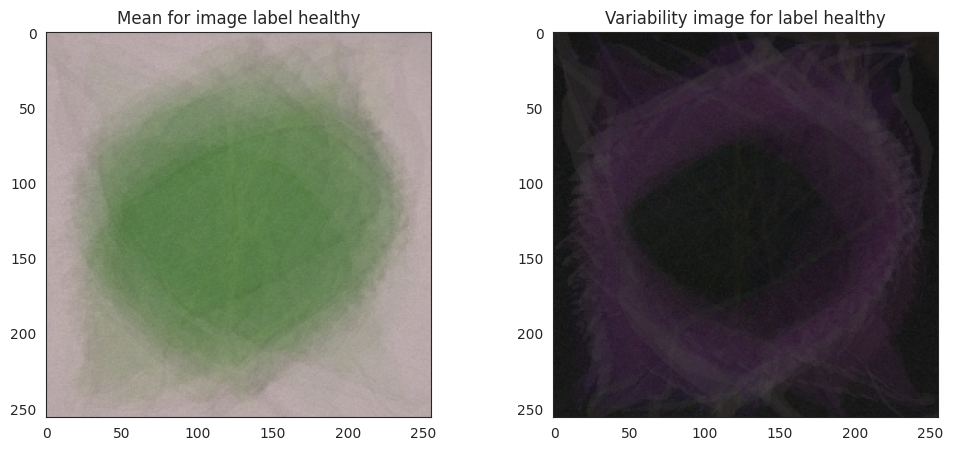

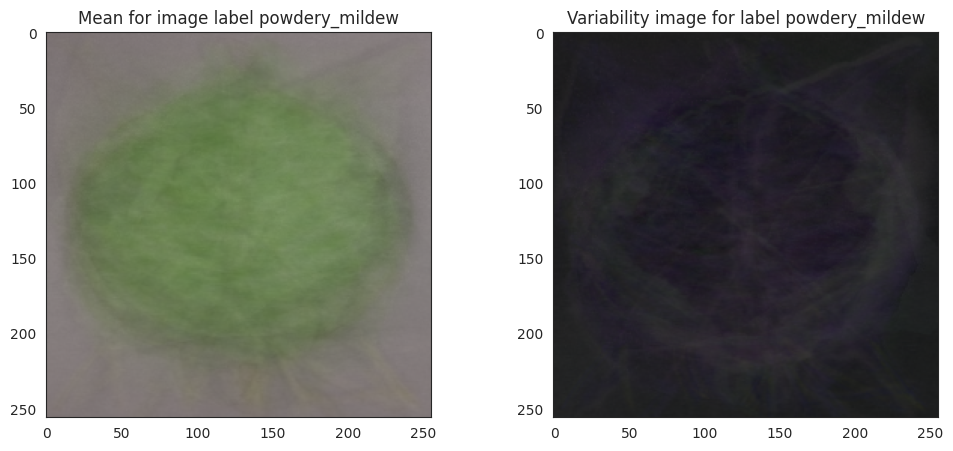

In [31]:
plot_average_variability_per_labels(X=X, y=y, figsize=(12, 5), save_img=True)